# импорт библиотек

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# http://stat.gibdd.ru/ Москва 2019

In [39]:
dtp_train = pd.read_csv('train (3).csv')

In [40]:
print('размер dtp_train: ', dtp_train.shape)

размер dtp_train:  (32516, 31)


In [41]:
dtp_train.head(2)

,id,victims,geom_buffer,typ_cod,nlevel,btf,oneway,surface,splitter,speedlim,...,rd_e_name,rd_l_name,f_parking,t_parking,bicyclanes,geom_buffer_length,EDGEID,TYP_COD,avg_check_speed,cnt_fix
0,19541622,0.0,"POLYGON ((36.8413497899442 55.4294441925851, 3...",7700,4,0,0,4,0,60,...,NaN,NaN,0,0,0,0.001581,19541622,7813,0.0,0.0
1,19541615,0.0,"POLYGON ((36.8466870400556 55.4185527970639, 3...",7700,3,0,0,2,1,60,...,NaN,46К-3230,0,0,0,0.002759,19541615,7813,0.0,0.0


# Будем решать задачу регрессии для прогноза пострадавших (столбец victims)

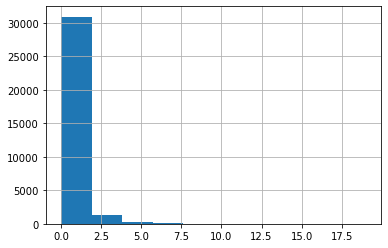

In [42]:
dtp_train['victims'].hist()

# посчитаем дисбаланс между нулевыми значениями и значениями больше 0

In [43]:
# посчитаем дисбаланс классов
total = dtp_train['victims'].value_counts()
count_0 = total[0]
count_more_0 = sum(total)-total[0]
print('количество 0 составляет {}%, а количество значений > 0 составляет {}%.'
      .format(round(count_0 * 100 / sum(total),1), round(count_more_0 * 100 / sum(total),1)))

количество 0 составляет 83.5%, а количество значений > 0 составляет 16.5%.


# Проверим наличие пустых значений и посмотрим тип данных в колонках

In [44]:
dtp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32516 entries, 0 to 32515
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  32516 non-null  int64  
 1   victims             32516 non-null  float64
 2   geom_buffer         32516 non-null  object 
 3   typ_cod             32516 non-null  int64  
 4   nlevel              32516 non-null  int64  
 5   btf                 32516 non-null  int64  
 6   oneway              32516 non-null  int64  
 7   surface             32516 non-null  int64  
 8   splitter            32516 non-null  int64  
 9   speedlim            32516 non-null  int64  
 10  f_rspeed            32516 non-null  int64  
 11  t_rspeed            32516 non-null  int64  
 12  lanewidth           32516 non-null  int64  
 13  f_lanes             32516 non-null  int64  
 14  t_lanes             32516 non-null  int64  
 15  f_sidewalk          32516 non-null  int64  
 16  t_si

# печать информации по пропущенным значениям в таблице

In [45]:
# печать информации по пропущенным значениям в таблице
def check_na_labels(df):
    total = {}
    for col in df.columns:
        pct_missing = np.mean(df[col].isnull())
        total[col] = round(pct_missing * 100)
        print('{} - {}%'.format(col, round(pct_missing*100)))

In [46]:
check_na_labels(dtp_train)

id - 0.0%
victims - 0.0%
geom_buffer - 0.0%
typ_cod - 0.0%
nlevel - 0.0%
btf - 0.0%
oneway - 0.0%
surface - 0.0%
splitter - 0.0%
speedlim - 0.0%
f_rspeed - 0.0%
t_rspeed - 0.0%
lanewidth - 0.0%
f_lanes - 0.0%
t_lanes - 0.0%
f_sidewalk - 0.0%
t_sidewalk - 0.0%
f_buslanes - 0.0%
t_buslanes - 0.0%
multidigit - 0.0%
rd_name - 17.0%
rd_e_name - 100.0%
rd_l_name - 95.0%
f_parking - 0.0%
t_parking - 0.0%
bicyclanes - 0.0%
geom_buffer_length - 0.0%
EDGEID - 0.0%
TYP_COD - 0.0%
avg_check_speed - 0.0%
cnt_fix - 0.0%


# Много пропущенных значений для названий дорог

In [47]:
dtp_train = dtp_train.drop(['rd_e_name', 'rd_l_name'], axis=1)

In [48]:
dtp_train = dtp_train.dropna()

# работа с rd_name

In [49]:
dtp_train['rd_name'] = LabelEncoder().fit_transform(dtp_train['rd_name'])

# corrmatrix

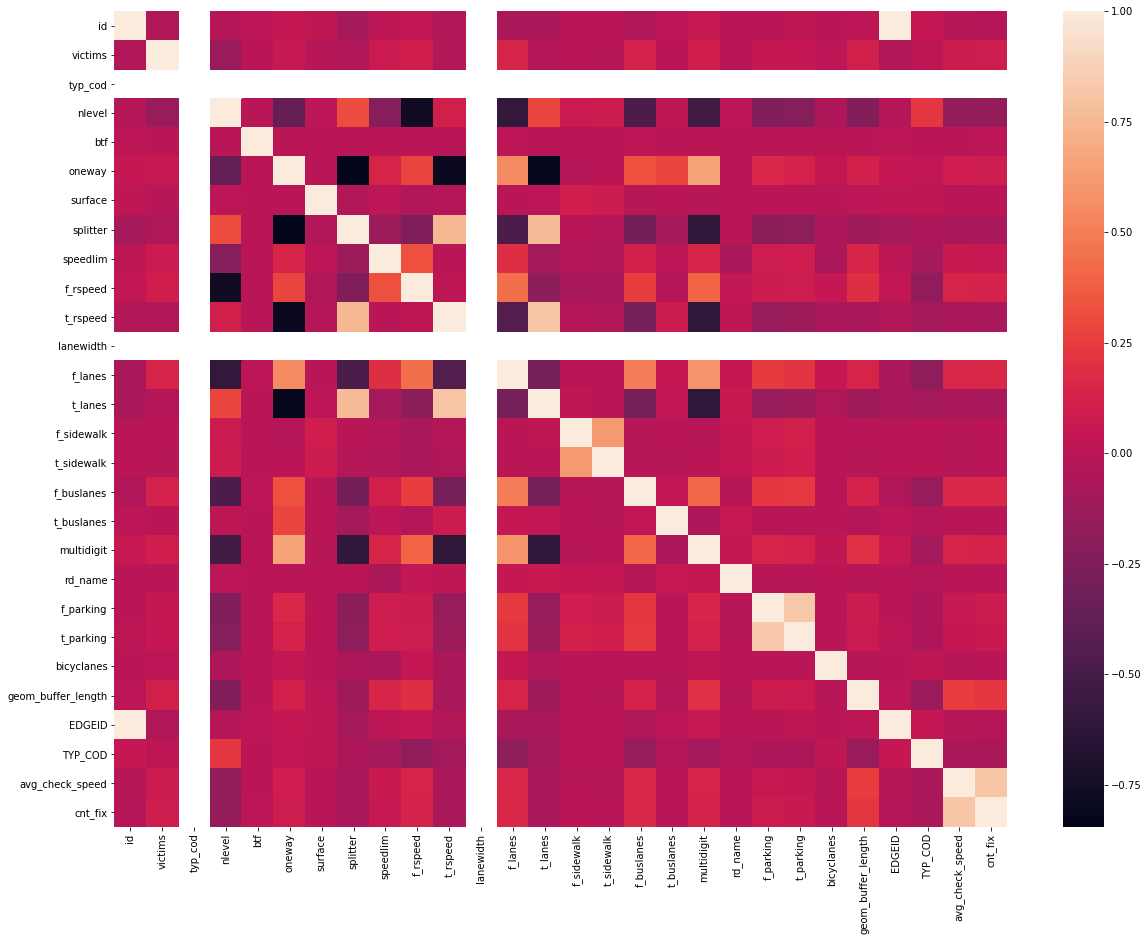

In [50]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(dtp_train.corr(), fmt='.2f')

# уберем один из признаков с корреляцией 1, а также те, что коррелируют со всеми остальными.

In [51]:
final_dtp = dtp_train.drop(['cnt_fix', 'typ_cod', 'lanewidth', 'f_parking', 'f_sidewalk', 'speedlim'], axis=1)

In [52]:
X = final_dtp.drop(['id', 'victims', 'geom_buffer', 'EDGEID'],axis=1)
y = final_dtp['victims']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# метрики. Выбор метрик связан во-первых с соответствием прогноза тестовому множеству (mean_absolute_error, mean_squared_error), а также объяснемой долей дисперсии (r2)

In [54]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()    

In [55]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [56]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [79]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [80]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
LinearRegression()

MAE=0.417, MSE=0.489, R2=0.026
*****************************************************
*****************************************************
KNeighborsRegressor()

MAE=0.399, MSE=0.569, R2=-0.134
*****************************************************
*****************************************************
SVR()

MAE=0.319, MSE=0.525, R2=-0.046
*****************************************************
*****************************************************
DecisionTreeRegressor()

MAE=0.42, MSE=0.991, R2=-0.974
*****************************************************
*****************************************************
RandomForestRegressor()

MAE=0.406, MSE=0.526, R2=-0.048
*****************************************************
*****************************************************
GradientBoostingRegressor()

MAE=0.412, MSE=0.479, R2=0.047
*****************************************************


In [63]:
%%time
tuned_parameters = {'max_depth': [1,3,5,7],
                    'n_estimators': [100,50],
                   'min_samples_leaf': [1,2,3]}
gs = GridSearchCV(RandomForestRegressor(random_state=42), tuned_parameters, scoring='r2')
gs.fit(X_train,y_train)

Wall time: 2min 25s


GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'max_depth': [1, 3, 5, 7],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [100, 50]},
             scoring='r2')

In [64]:
gs.best_estimator_

GradientBoostingRegressor(max_depth=5, min_samples_leaf=3, random_state=42)

In [65]:
regr_models_grid = {'GB': gs.best_estimator_}

In [78]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
GradientBoostingRegressor(max_depth=5, min_samples_leaf=3, random_state=42)

MAE=0.408, MSE=0.486, R2=-7.166
*****************************************************


# Проверка на тесте и сравнение прогноза и теста

(array([6.445e+03, 2.100e+02, 6.800e+01, 2.300e+01, 1.400e+01, 1.400e+01,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

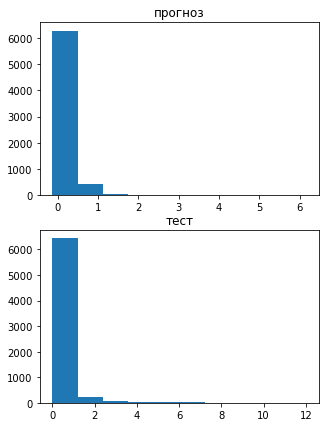

In [75]:

best_GB = gs.best_estimator_
predict = best_GB.predict(X_test)

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5,7))
ax1.set_title('прогноз')
ax1.hist(predict)
ax2.set_title('тест')
ax2.hist(y_test)